In [1]:
import torch
import os
import numpy as np
import cv2

import matplotlib.pyplot as plt
%matplotlib inline

import onnxruntime

## path

### cityscapes

In [2]:
# fast-scnn
onnx_path = './mmdeploy/outputs/mmseg2onnx_cityscapes_fastscnn/end2end.onnx'

In [3]:
ort_session = onnxruntime.InferenceSession(onnx_path, providers=['CUDAExecutionProvider', 'CPUExecutionProvider'])

/home/wmy/anaconda3/envs/mmseg/lib/python3.8/site-packages/onnxruntime/capi/onnxruntime_inference_collection.py:65: UserWarning: Specified provider 'CUDAExecutionProvider' is not in available provider names.Available providers: 'CPUExecutionProvider'
  warnings.warn(


## onnxruntime

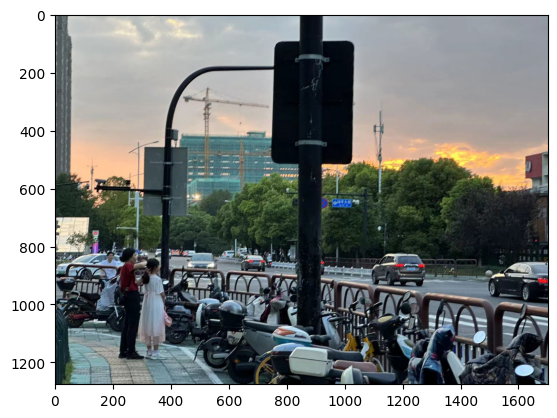

In [4]:
img_path = 'mmsegmentation/data/street.jpg'
img_bgr = cv2.imread(img_path)

plt.imshow(img_bgr[:,:,::-1])
plt.show()

In [5]:
# 获取原图宽高
h, w = img_bgr.shape[0], img_bgr.shape[1]
h, w

(1276, 1702)

### 图像变形
需要看 `pipeline.json` 对宽、高的要求

In [6]:
# 缩放尺寸
# (2048, 1024)需要根据json文件调整
img_bgr_resize = cv2.resize(img_bgr, (2048, 1024)) 
img_bgr_resize.shape

(1024, 2048, 3)

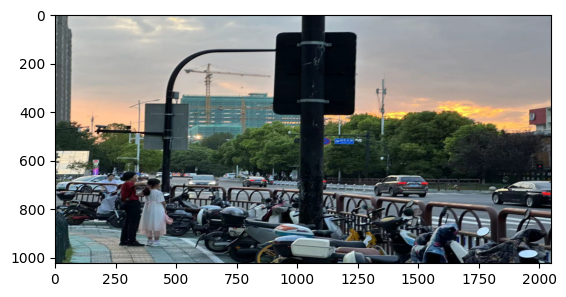

In [7]:
plt.imshow(img_bgr_resize[:,:,::-1])
plt.show()

### 预处理

In [8]:
img_tensor = img_bgr_resize

# BGR 三通道的均值
mean = (123.675, 116.28, 103.53)
# BGR 三通道的标准差
std = (58.395, 57.12, 57.375)

# 归一化
img_tensor = (img_tensor - mean) / std
img_tensor = img_tensor.astype('float32')

# BGR 转 RGB
img_tensor = cv2.cvtColor(img_tensor, cv2.COLOR_BGR2RGB)
# 调整维度
img_tensor = np.transpose(img_tensor, (2, 0, 1))
# 扩充 batch-size 维度
input_tensor = np.expand_dims(img_tensor, axis=0)

print(input_tensor.shape)

(1, 3, 1024, 2048)


### ONNX Runtime

In [9]:
# ONNX Runtime 输入
ort_inputs = {'input': input_tensor}

In [10]:
# onnx runtime 输出
ort_output = ort_session.run(['output'], ort_inputs)[0]
ort_output.shape            # 二进制输出，分割图像

(1, 1, 1024, 2048)

In [11]:
pred_mask = ort_output[0][0]
# 类别
pred_mask, np.unique(pred_mask)

(array([[8, 8, 8, ..., 2, 2, 2],
        [8, 8, 8, ..., 2, 2, 2],
        [8, 8, 8, ..., 2, 2, 2],
        ...,
        [4, 4, 4, ..., 0, 0, 0],
        [4, 4, 4, ..., 0, 0, 0],
        [4, 4, 4, ..., 0, 0, 0]], dtype=int64),
 array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 11, 12, 13, 15, 16, 18],
       dtype=int64))

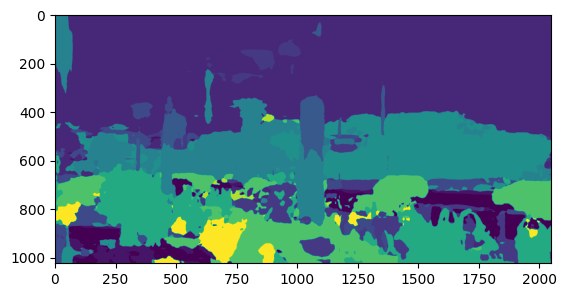

In [12]:
plt.imshow(pred_mask)
plt.show()

In [13]:
from mmseg.datasets.ade import ADE20KDataset
from mmseg.datasets.cityscapes import CityscapesDataset

def config_palette(dataset):
    if dataset == 'cityscapes':
        METAINFO = CityscapesDataset.METAINFO
        palette = [[class_name, color] for class_name, color in zip(METAINFO['classes'], METAINFO['palette'])]
    elif dataset == 'ade20k':
        METAINFO = ADE20KDataset.METAINFO
        palette = [[class_name, color] for class_name, color in zip(METAINFO['classes'], METAINFO['palette'])]
    elif dataset == 'watermelon':
        palette = [
            ['background', [127,127,127]],
            ['red', [0,0,200]],
            ['green', [0,200,0]],
            ['white', [144,238,144]],
            ['seed-black', [30,30,30]],
            ['seed-white', [8,189,251]]]

    palette_dict = {}
    for idx, each in enumerate(palette):
        palette_dict[idx] = each[1]

    return palette_dict

In [14]:
opacity = 0.3 # 透明度，越大越接近原图
palette_dict = config_palette('cityscapes')

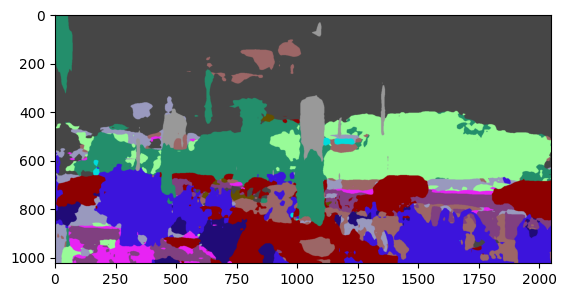

In [15]:
# 将预测的整数ID，映射为对应类别的颜色
pred_mask_bgr = np.zeros((pred_mask.shape[0], pred_mask.shape[1], 3))
for idx in palette_dict.keys():
    pred_mask_bgr[np.where(pred_mask==idx)] = palette_dict[idx]
pred_mask_bgr = pred_mask_bgr.astype('uint8')

plt.imshow(pred_mask_bgr[:,:,::-1])
plt.show()

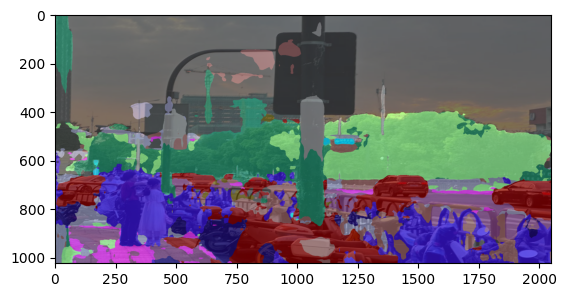

In [16]:
# 将语义分割预测图和原图叠加显示
pred_viz = cv2.addWeighted(img_bgr_resize, opacity, pred_mask_bgr, 1-opacity, 0)
plt.imshow(pred_viz[:,:,::-1])
plt.show()

## Main

In [4]:
import json
import cv2
from mmseg.datasets.ade import ADE20KDataset
from mmseg.datasets.cityscapes import CityscapesDataset

def config_palette(dataset):
    if dataset == 'cityscapes':
        METAINFO = CityscapesDataset.METAINFO
        palette = [[class_name, color] for class_name, color in zip(METAINFO['classes'], METAINFO['palette'])]
    elif dataset == 'ade20k':
        METAINFO = ADE20KDataset.METAINFO
        palette = [[class_name, color] for class_name, color in zip(METAINFO['classes'], METAINFO['palette'])]
    elif dataset == 'watermelon':
        palette = [
            ['background', [127,127,127]],
            ['red', [0,0,200]],
            ['green', [0,200,0]],
            ['white', [144,238,144]],
            ['seed-black', [30,30,30]],
            ['seed-white', [8,189,251]]]

    palette_dict = {}
    for idx, each in enumerate(palette):
        palette_dict[idx] = each[1]

    return palette_dict


def main(dataset, onnx_path, img_path, pipeline_json_path, opacity = 0.3):
    img_bgr = cv2.imread(img_path)
    
    with open(pipeline_json_path, 'r') as json_file:
        data = json.load(json_file)
    
    # 访问 "size" 字段的值
    size = data["pipeline"]["tasks"][0]["transforms"][1]["size"]
    # 访问 "mean" 字段的值
    mean = data["pipeline"]["tasks"][0]["transforms"][2]["mean"]
    # 访问 "std" 字段的值
    std = data["pipeline"]["tasks"][0]["transforms"][2]["std"]
    
    bgr_size = (size[0], size[1])
    bgr_mean = (mean[2], mean[1], mean[0])
    bgr_std = (std[2], std[1], std[0])
    
    print(bgr_size)
    
    img_bgr_resize = cv2.resize(img_bgr, bgr_size)
    img_tensor = img_bgr_resize
     
    # 归一化
    img_tensor = (img_tensor - bgr_mean) / bgr_std
    img_tensor = img_tensor.astype('float32')
    
    # BGR 转 RGB
    img_tensor = cv2.cvtColor(img_tensor, cv2.COLOR_BGR2RGB)
    # 调整维度
    img_tensor = np.transpose(img_tensor, (2, 0, 1))
    # 扩充 batch-size 维度
    input_tensor = np.expand_dims(img_tensor, axis=0)
    
    ### ONNX Runtime
    ort_session = onnxruntime.InferenceSession(onnx_path, providers=['CUDAExecutionProvider', 'CPUExecutionProvider'])
    # ONNX Runtime 输入
    ort_inputs = {'input': input_tensor}
    # onnx runtime 输出
    ort_output = ort_session.run(['output'], ort_inputs)[0]
    ort_output.shape            # 二进制输出，分割图像
    
    # mask
    pred_mask = ort_output[0][0]
    # 类别
    pred_mask, np.unique(pred_mask)
    
    # opacity = 0.3 # 透明度，越大越接近原图
    palette_dict = config_palette(dataset)
    
    # 将预测的整数ID，映射为对应类别的颜色
    pred_mask_bgr = np.zeros((pred_mask.shape[0], pred_mask.shape[1], 3))
    for idx in palette_dict.keys():
        pred_mask_bgr[np.where(pred_mask==idx)] = palette_dict[idx]
    pred_mask_bgr = pred_mask_bgr.astype('uint8')
    
    # 将语义分割预测图和原图叠加显示
    pred_viz = cv2.addWeighted(img_bgr_resize, opacity, pred_mask_bgr, 1-opacity, 0)
    plt.imshow(pred_viz[:,:,::-1])
    plt.show()

## cityscapes

### FastSCNN

(2048, 1024)


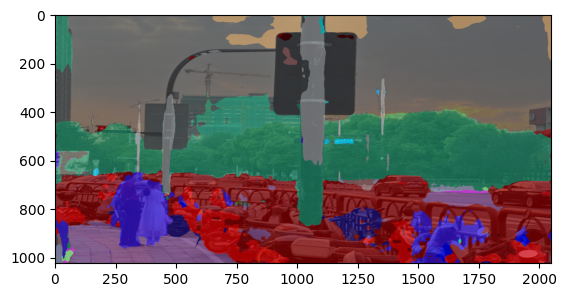

In [6]:
dataset = 'cityscapes'
onnx_path = './mmdeploy/outputs/mmseg2onnx_cityscapes_fastscnn/end2end.onnx'
img_path = 'mmsegmentation/data/street.jpg'
pipeline_json_path = './mmdeploy/outputs/mmseg2onnx_cityscapes_fastscnn/pipeline.json'

main(dataset, onnx_path, img_path, pipeline_json_path)

### BiSeNetV2

(2048, 1024)


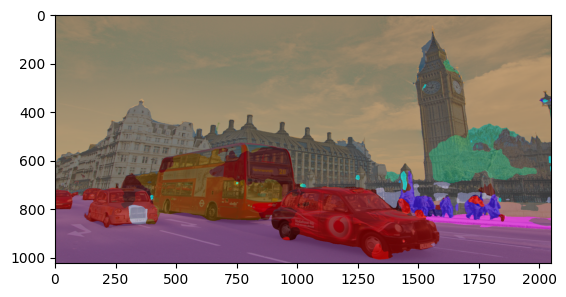

In [5]:
dataset = 'cityscapes'
img_path = './mmsegmentation/data/street_uk.jpeg'
onnx_path = './mmdeploy/outputs/mmseg2onnx_cityscapes_BiSeNetV2/end2end.onnx'
pipeline_json_path = './mmdeploy/outputs/mmseg2onnx_cityscapes_BiSeNetV2/pipeline.json'

main(dataset, onnx_path, img_path, pipeline_json_path)

## ade20K

### deeplabv3+

(2048, 512)


/home/wmy/anaconda3/envs/mmseg/lib/python3.8/site-packages/onnxruntime/capi/onnxruntime_inference_collection.py:65: UserWarning: Specified provider 'CUDAExecutionProvider' is not in available provider names.Available providers: 'CPUExecutionProvider'
  warnings.warn(


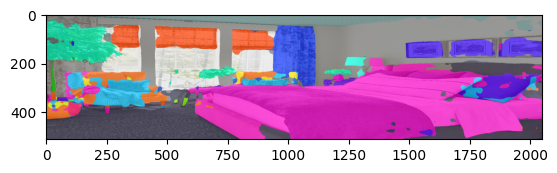

In [7]:
dataset = 'ade20k'
img_path = './mmsegmentation/data/bedroom.jpg'
onnx_path = './mmdeploy/outputs/mmseg2onnx_ade20k_deeplabv3+/end2end.onnx'
pipeline_json_path = './mmdeploy/outputs/mmseg2onnx_ade20k_deeplabv3+/pipeline.json'

main(dataset, onnx_path, img_path, pipeline_json_path)

### pspnet

(2048, 512)


/home/wmy/anaconda3/envs/mmseg/lib/python3.8/site-packages/onnxruntime/capi/onnxruntime_inference_collection.py:65: UserWarning: Specified provider 'CUDAExecutionProvider' is not in available provider names.Available providers: 'CPUExecutionProvider'
  warnings.warn(


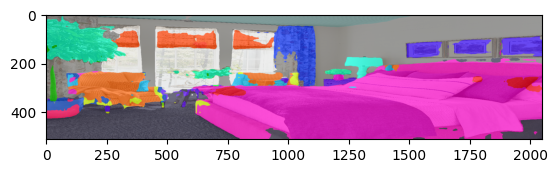

In [8]:
dataset = 'ade20k'
img_path = './mmsegmentation/data/bedroom.jpg'
onnx_path = './mmdeploy/outputs/mmseg2onnx_ade20k_pspnet/end2end.onnx'
pipeline_json_path = './mmdeploy/outputs/mmseg2onnx_ade20k_pspnet/pipeline.json'
main(dataset, onnx_path, img_path, pipeline_json_path)